In [3]:
from pathlib import Path 
import pandas as pd
import matplotlib.pyplot as plt
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [4]:
file_path = Path("../data/example_data.hd5")
df = pd.read_hdf(file_path)
df = df.reset_index()
df.head()

,PropertyID,DateTime,Value
0,300468,2020-01-01 00:00:00,65.992325
1,300468,2020-01-01 00:00:30,59.085239
2,300468,2020-01-01 00:01:00,63.399876
3,300468,2020-01-01 00:01:30,74.437500
4,300468,2020-01-01 00:02:00,60.391750


In [5]:
df = df.pivot(index='DateTime', columns='PropertyID', values='Value')
df.columns = [str(col) for col in df.columns]
df = df.reset_index()
df.rename(columns={'DateTime':'date'}, inplace=True)
df.fillna(method='ffill', inplace=True)
df = df.sort_values(by='date')
df.head()

,date,300468,300498,305256,315036,340686,341124,341550
0,2020-01-01 00:00:00,65.992325,2036.845581,58.777546,114.388023,1.737929,5.342316,1.386370
1,2020-01-01 00:00:30,59.085239,2036.845581,67.127098,114.388023,1.691197,5.378604,1.403499
2,2020-01-01 00:01:00,63.399876,2036.780151,72.960365,114.293983,1.861186,5.308666,1.416289
3,2020-01-01 00:01:30,74.437500,2036.780151,71.723625,114.293983,1.830390,5.459568,1.512679
4,2020-01-01 00:02:00,60.391750,2036.780518,70.489014,114.120377,1.729635,5.588947,1.548172


In [6]:
def min_max_scaling_df(df):
    min_vals = df.min()
    max_vals = df.max()
    scaled_df = (df - min_vals) / (max_vals - min_vals)
    return scaled_df

def inverse_min_max_scaling_df(scaled_df, min_vals, max_vals):
    original_df = (scaled_df * (max_vals - min_vals)) + min_vals
    return original_df

In [7]:
property_columns = ['300468', '300498', '305256', '315036', '340686', '341124','341550']

for col in property_columns:
    df[col] = min_max_scaling_df(df[col])

In [8]:
df.head()

,date,300468,300498,305256,315036,340686,341124,341550
0,2020-01-01 00:00:00,0.208737,0.924735,0.226356,0.525346,0.444739,0.937828,0.778900
1,2020-01-01 00:00:30,0.168532,0.924735,0.468930,0.525346,0.423248,0.946206,0.792399
2,2020-01-01 00:01:00,0.193647,0.921531,0.638401,0.510369,0.501424,0.930058,0.802478
3,2020-01-01 00:01:30,0.257896,0.921531,0.602471,0.510369,0.487261,0.964900,0.878441
4,2020-01-01 00:02:00,0.176137,0.921549,0.566602,0.482720,0.440925,0.994772,0.906412


In [9]:
# Train-test split (you can adjust the split ratio)
train_size = int(0.8 * len(df))
train_df = df[:train_size]
test_df = df[train_size:]

In [10]:
train_df.shape

(2297, 8)

In [11]:
def aggregate_data_by_frequency(frequency, dataset, group):
    # Filter data for the given material category
    filtered_data = dataset.loc[:,["date",group]]
    
    # Set the 'date' column as the index
    filtered_data['date'] = pd.to_datetime(filtered_data['date'])
    filtered_data.set_index('date', inplace=True)
    
    # Resample the data based on the specified frequency
    aggregated_data = filtered_data.resample(frequency).agg({group: 'mean'})
    
    return aggregated_data


15:27:56 - cmdstanpy - INFO - Chain [1] start processing
15:27:56 - cmdstanpy - INFO - Chain [1] done processing


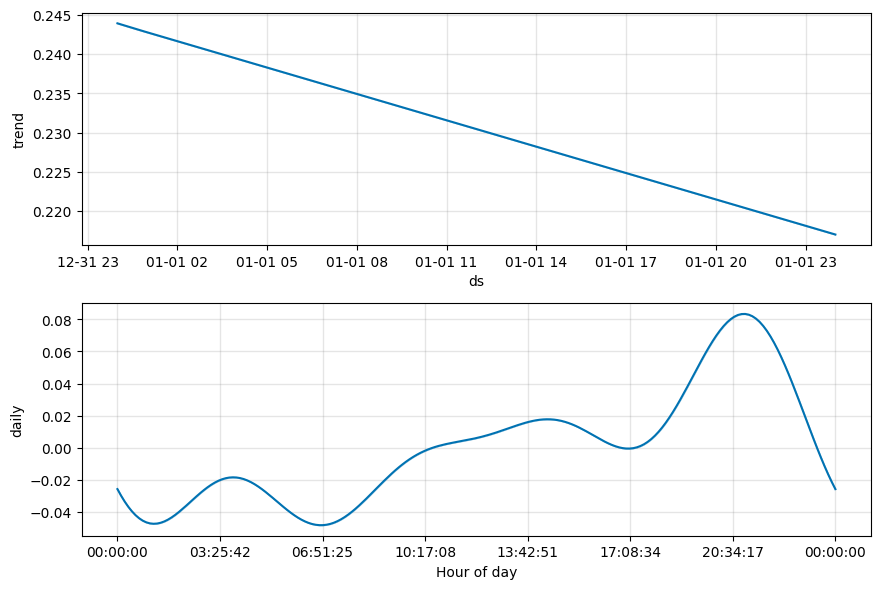

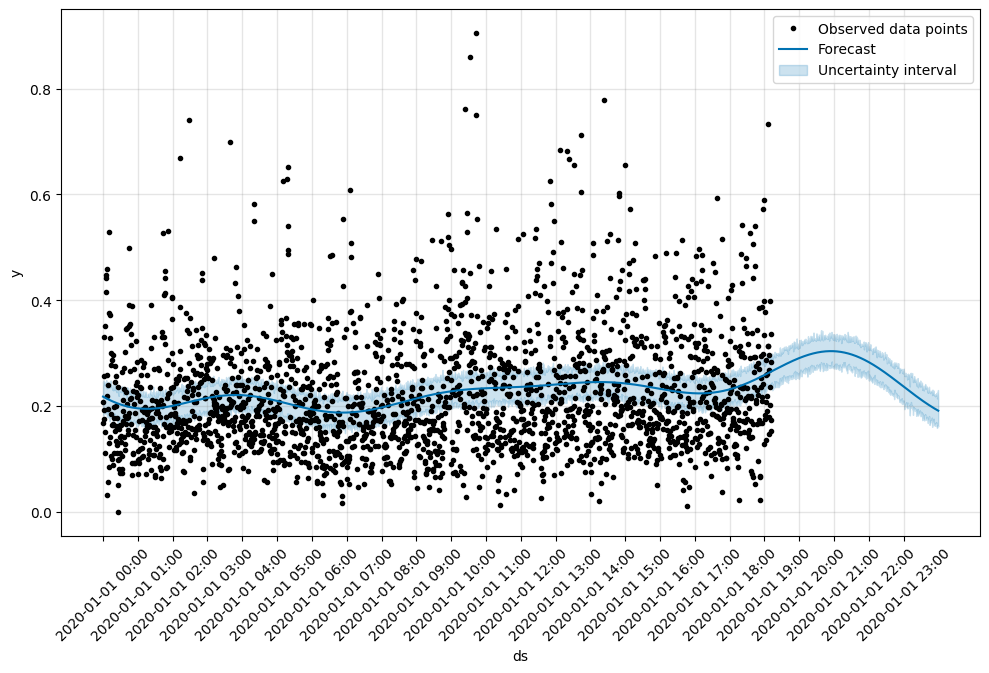

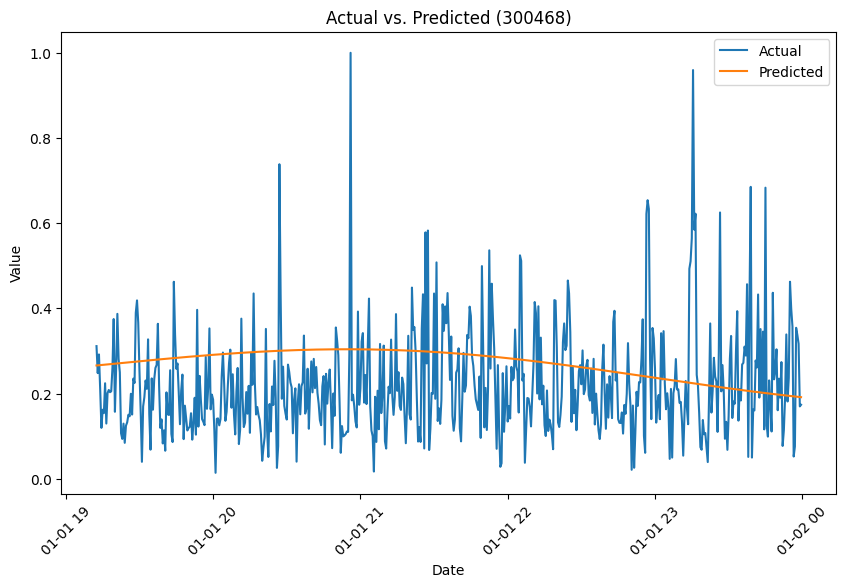

15:27:57 - cmdstanpy - INFO - Chain [1] start processing


MAE for 300468: 0.11
MSE for 300468: 0.02


15:27:57 - cmdstanpy - INFO - Chain [1] done processing


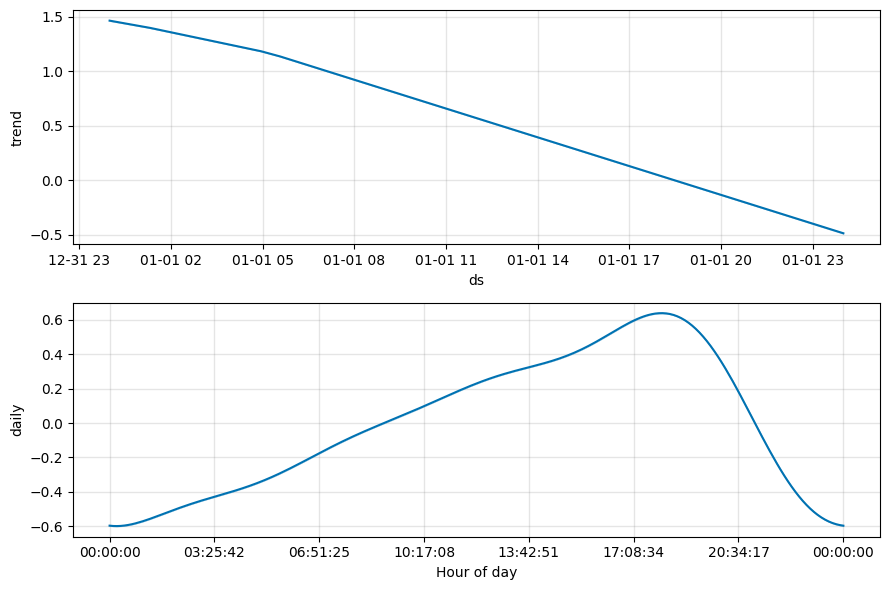

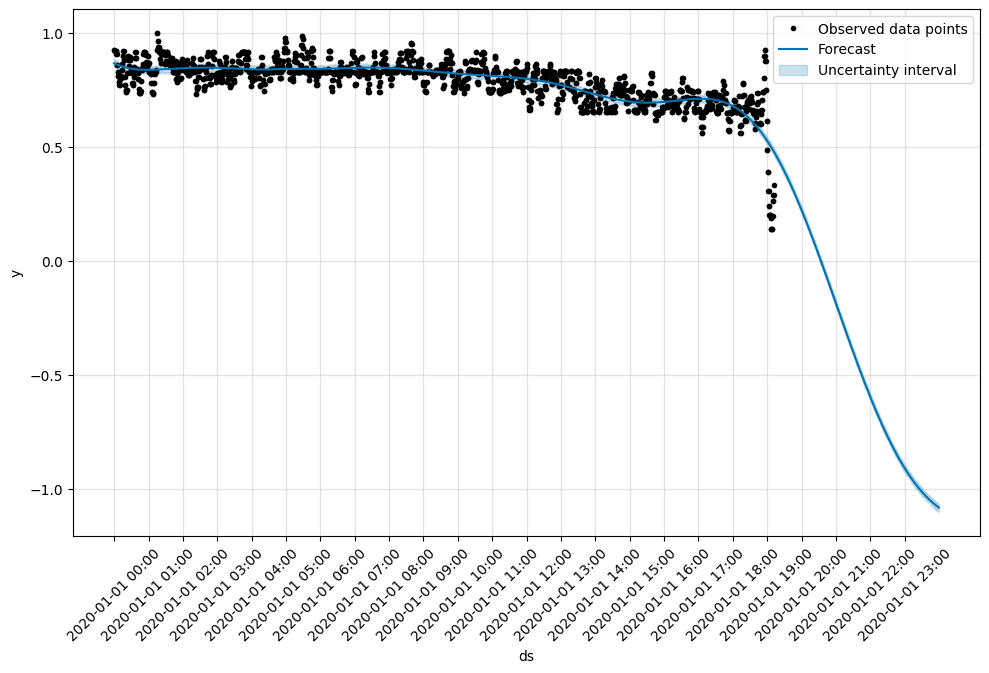

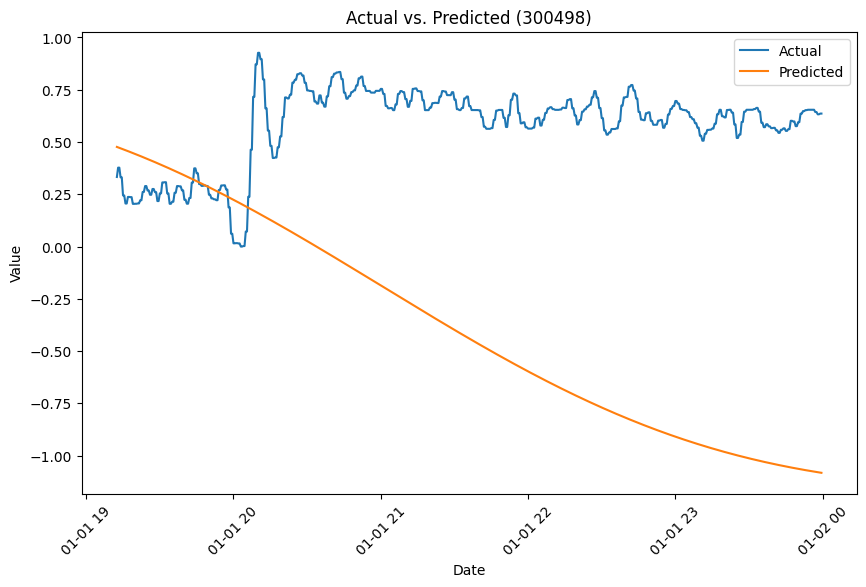

15:27:58 - cmdstanpy - INFO - Chain [1] start processing
15:27:58 - cmdstanpy - INFO - Chain [1] done processing


MAE for 300498: 1.01
MSE for 300498: 1.30


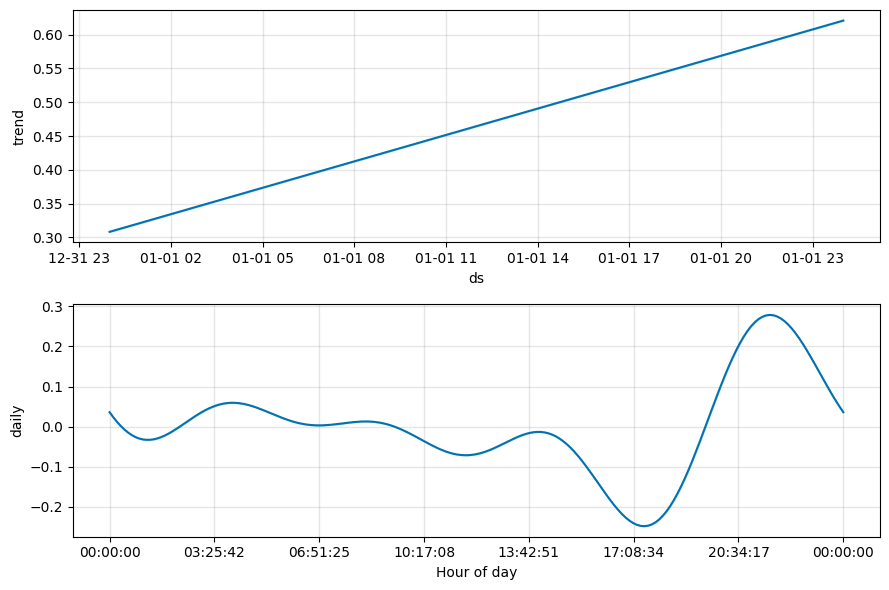

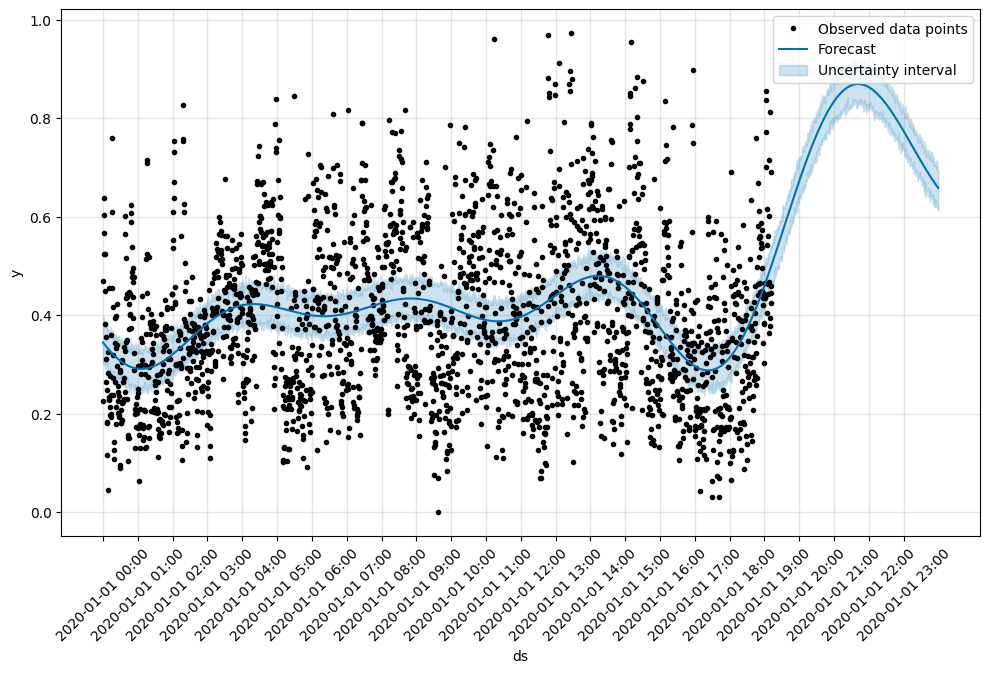

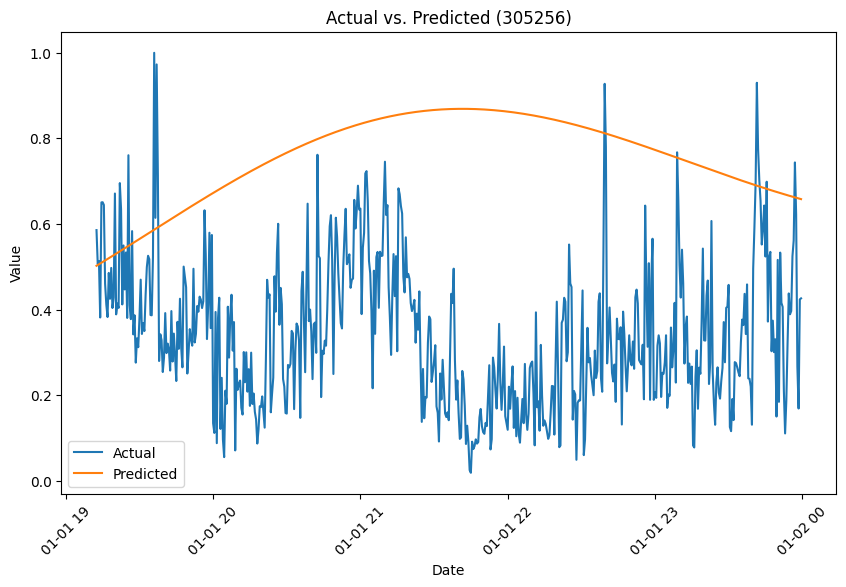

15:27:59 - cmdstanpy - INFO - Chain [1] start processing
15:27:59 - cmdstanpy - INFO - Chain [1] done processing


MAE for 305256: 0.42
MSE for 305256: 0.22


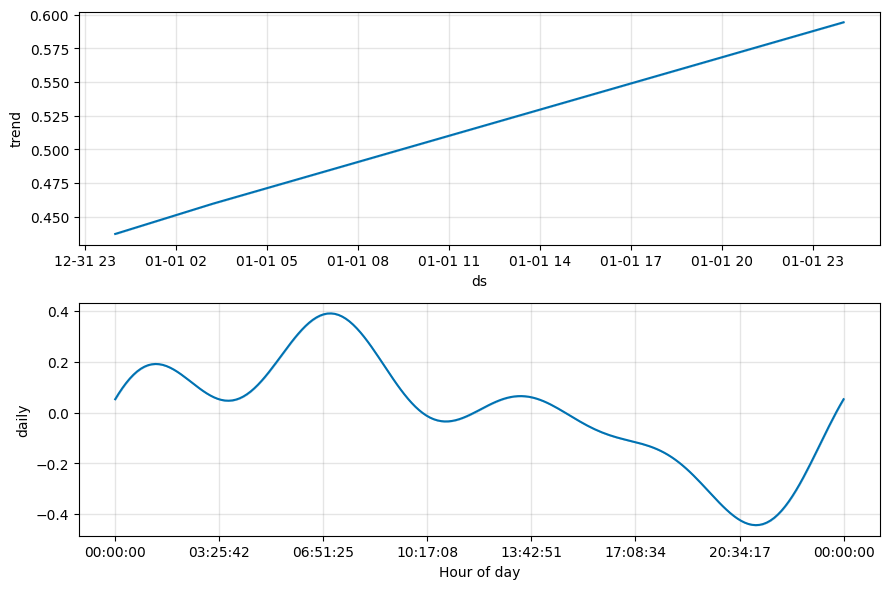

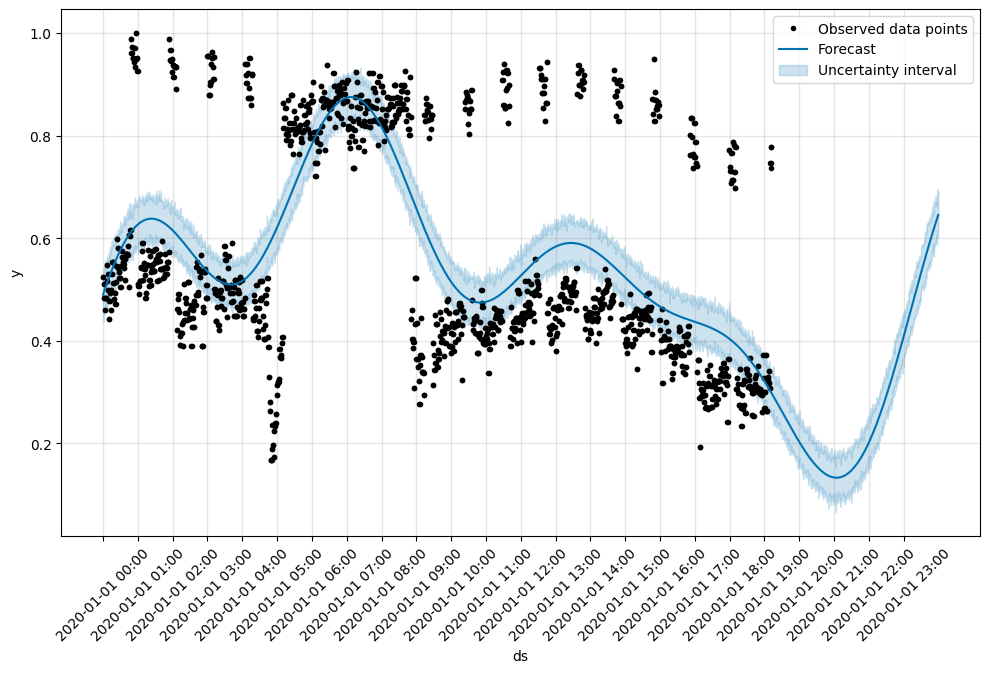

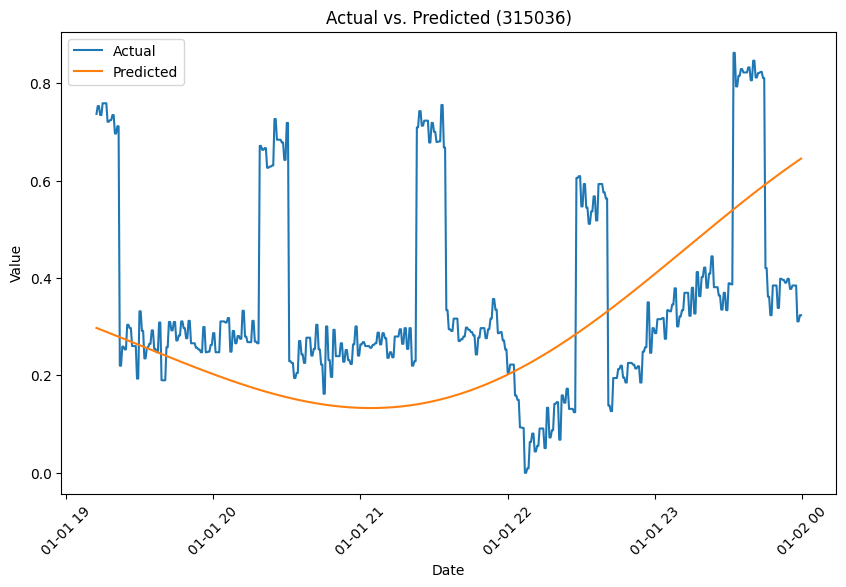

15:28:01 - cmdstanpy - INFO - Chain [1] start processing
15:28:01 - cmdstanpy - INFO - Chain [1] done processing


MAE for 315036: 0.17
MSE for 315036: 0.05


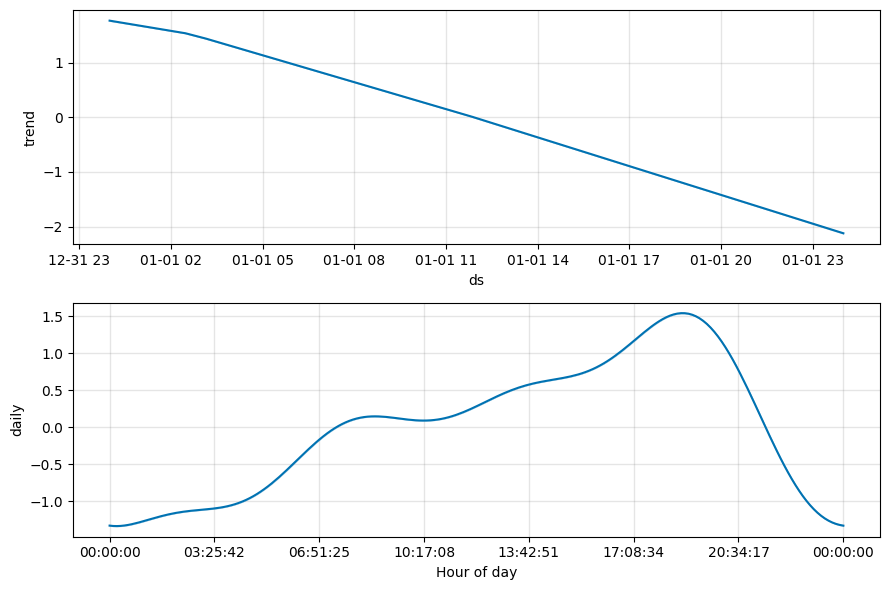

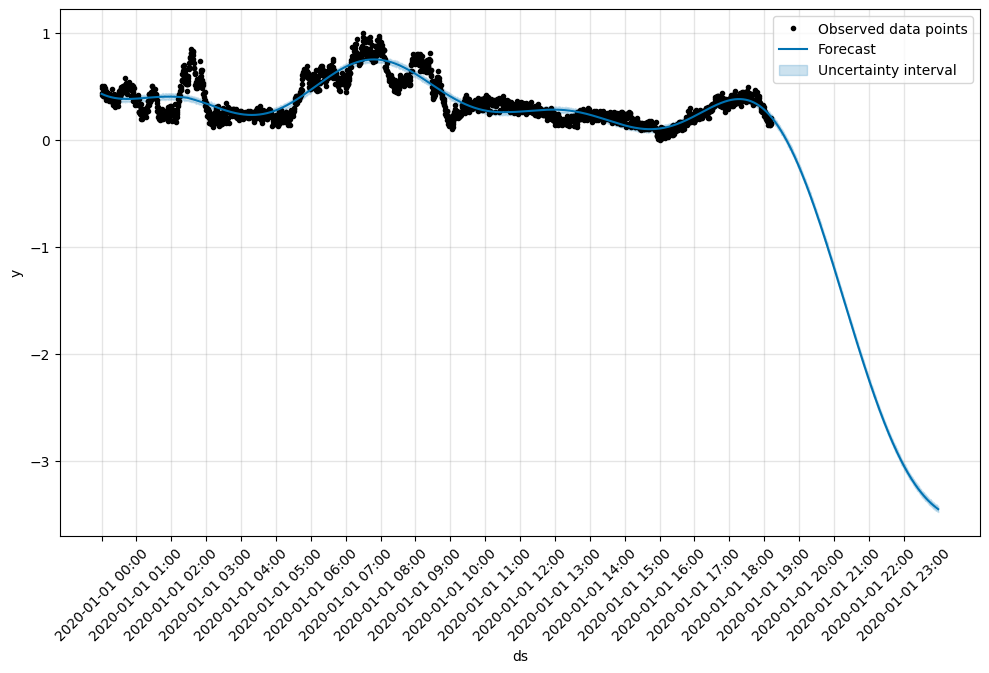

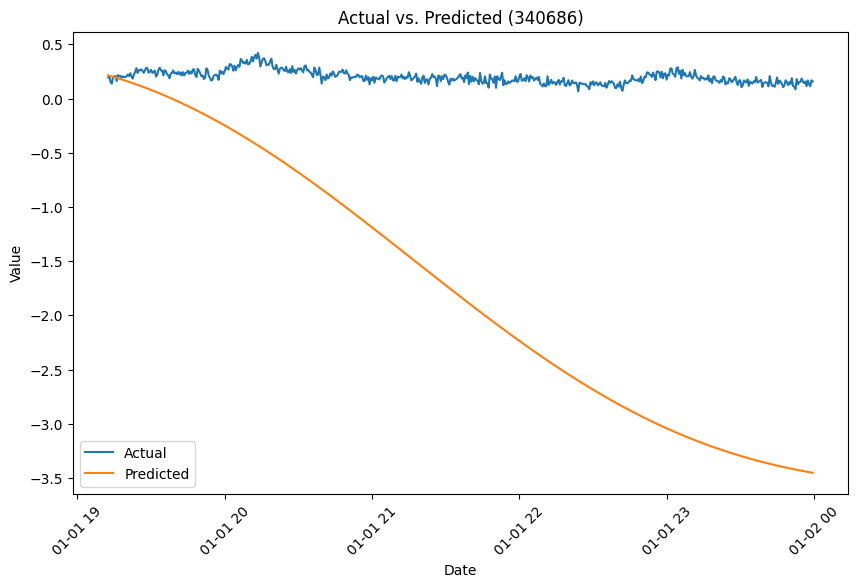

15:28:02 - cmdstanpy - INFO - Chain [1] start processing
15:28:02 - cmdstanpy - INFO - Chain [1] done processing


MAE for 340686: 1.94
MSE for 340686: 5.14


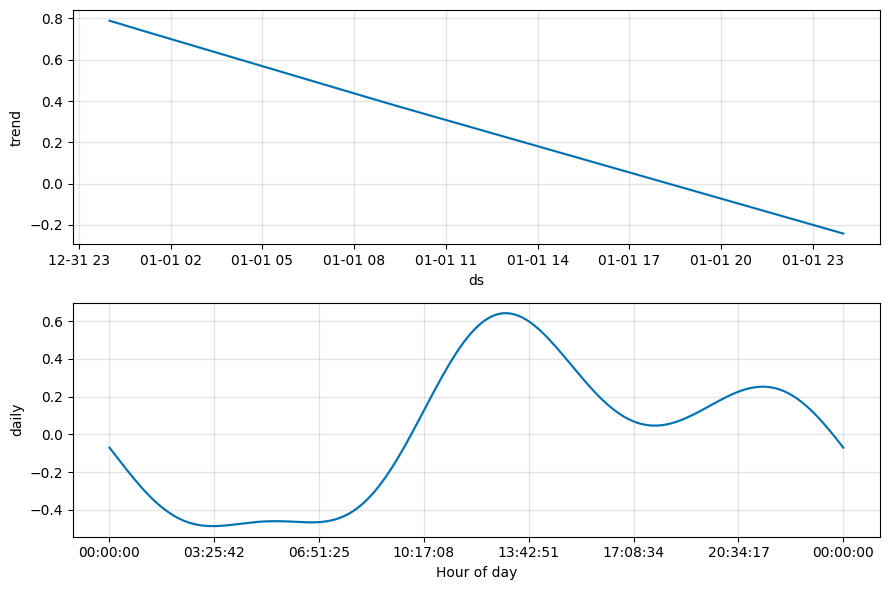

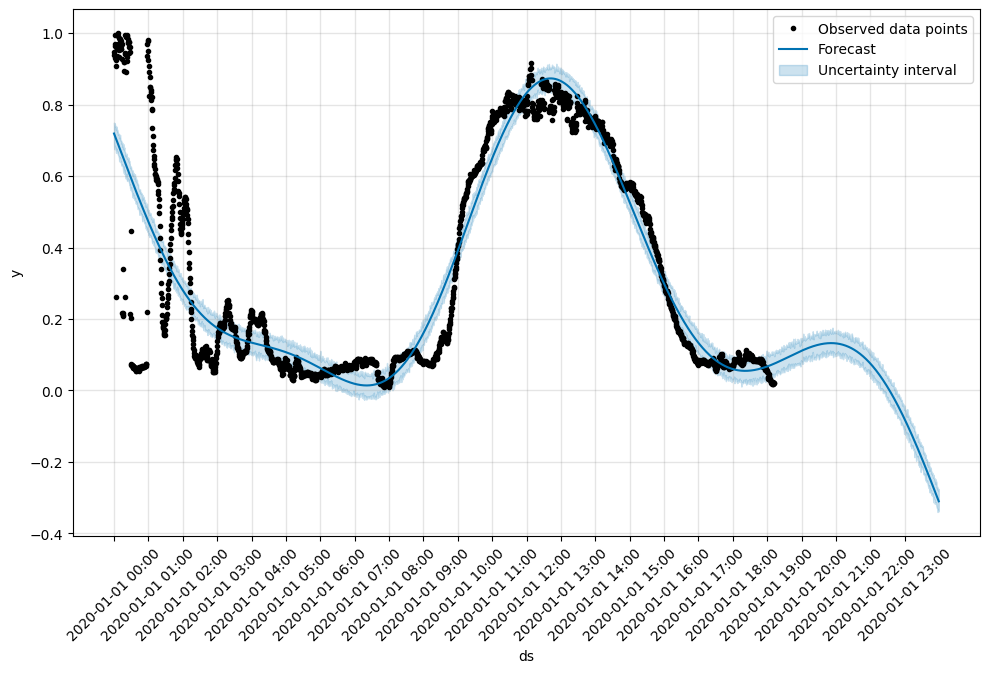

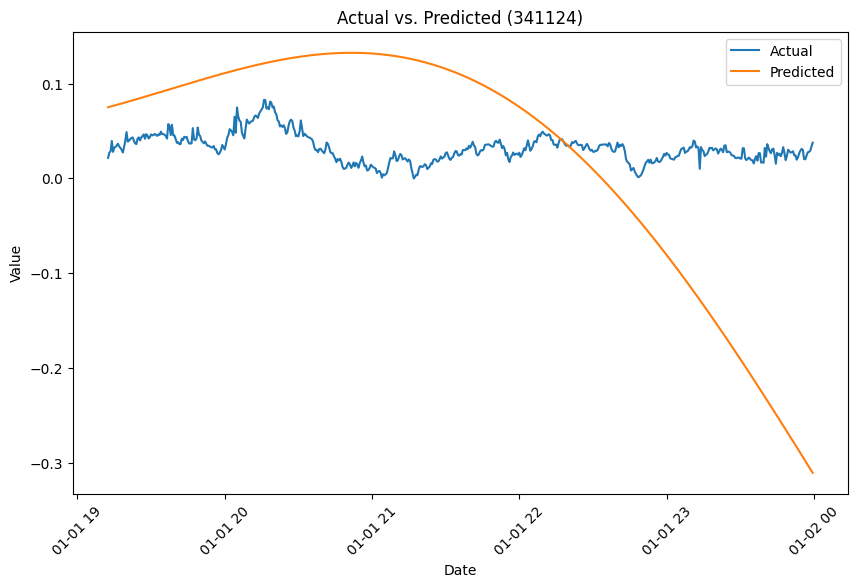

15:28:03 - cmdstanpy - INFO - Chain [1] start processing


MAE for 341124: 0.10
MSE for 341124: 0.02


15:28:03 - cmdstanpy - INFO - Chain [1] done processing


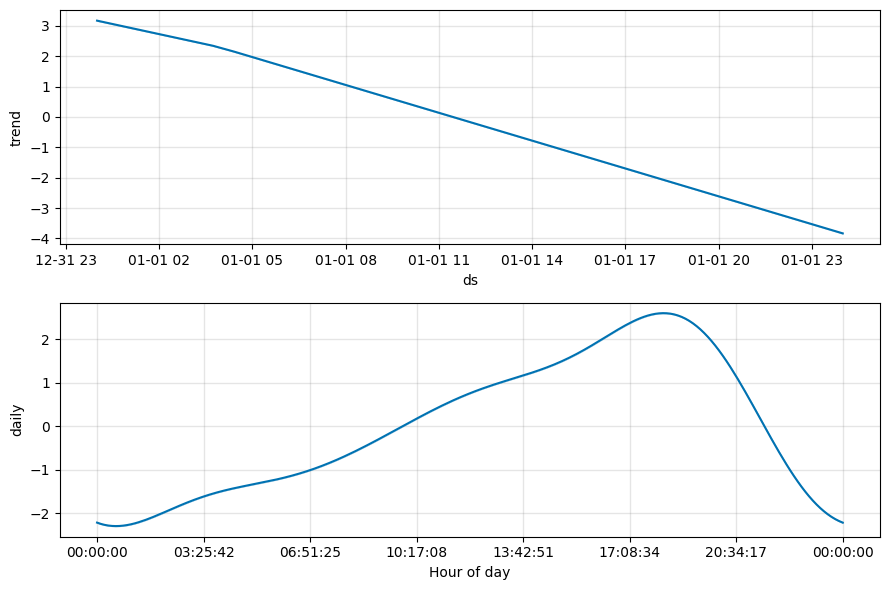

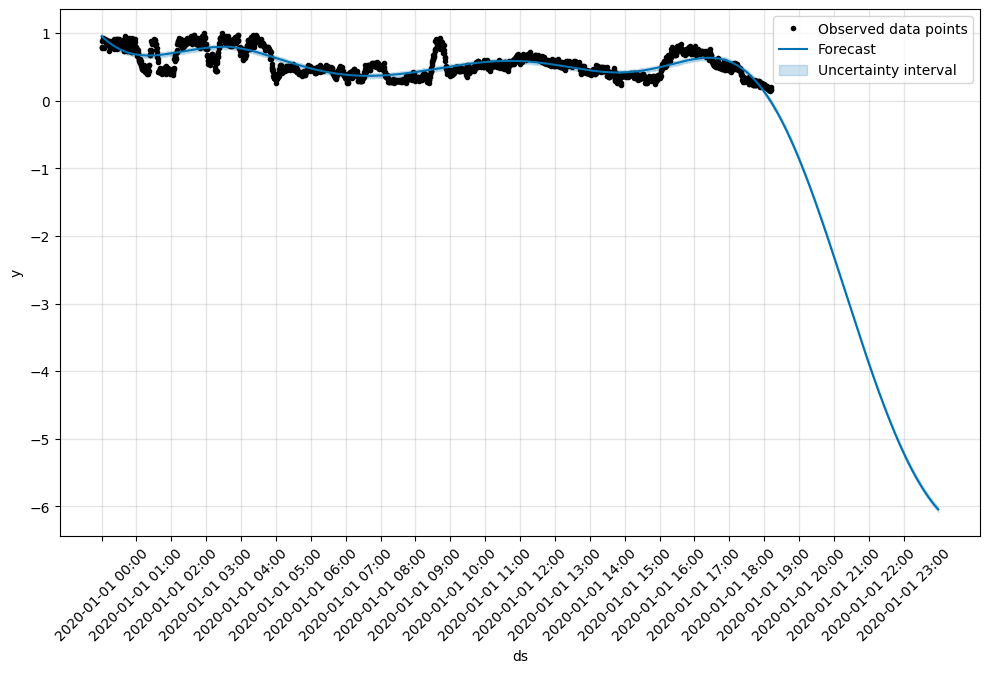

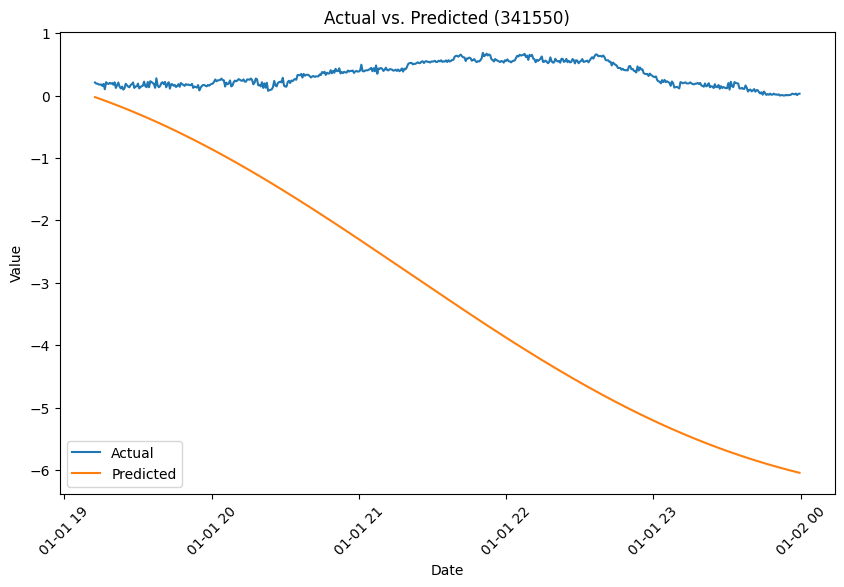

MAE for 341550: 3.50
MSE for 341550: 16.06


In [15]:
for property_col in property_columns:
    frequency = "30S"
    
    # Aggregate train data
    train_ag_data = aggregate_data_by_frequency(frequency, train_df, property_col)
    train_data = pd.DataFrame({
        'ds': train_ag_data.index,
        'y': train_ag_data[property_col]
    })

    # Train the Prophet model
    model = Prophet(interval_width=0.20, daily_seasonality=True)
    model.fit(train_data)

    # Aggregate test data
    test_ag_data = aggregate_data_by_frequency(frequency, test_df, property_col)
    test_data = pd.DataFrame({
        'ds': test_ag_data.index,
        'y': test_ag_data[property_col]
    })



    # Make predictions on test data
    future = model.make_future_dataframe(periods=len(test_data), freq=frequency)
    forecast = model.predict(future)

    # Plot the forecast Components
    model.plot_components(forecast)
    plt.show()

    fig = model.plot(forecast) # with train df fitting and test forecasting
    # Customize x-axis ticks to display hourly intervals
    hourly_ticks = pd.date_range(start=train_data['ds'].min(), end=forecast['ds'].max(), freq='H')
    plt.xticks(hourly_ticks, hourly_ticks.strftime('%Y-%m-%d %H:%M'), rotation=45)
    plt.legend()
    plt.show()


    # Calculate MAE and MSE
    y_true = test_data['y'].values
    y_pred = forecast['yhat'].values[-len(test_data):]
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)

    # Plot predictions and actual values for the last 200 steps
    last_steps = len(test_data)
    plt.figure(figsize=(10, 6))
    plt.plot(test_data['ds'].tail(last_steps), y_true[-last_steps:], label='Actual')
    plt.plot(test_data['ds'].tail(last_steps), y_pred[-last_steps:], label='Predicted')
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'Actual vs. Predicted ({property_col})')
    plt.legend()
    plt.xticks(rotation=45)
    plt.show()

    print(f'MAE for {property_col}: {mae:.2f}')
    print(f'MSE for {property_col}: {mse:.2f}')
